<a href="https://colab.research.google.com/github/shaikadish/imdbProject/blob/main/EDA_and_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lets take a look...

Before training begins, we need to see what exactly we have [scraped](https://github.com/shaikadish/imdbProject/blob/main/web_scraper.ipynb) from IMDB. This examination will take the form of Exploratory Data Analysis (EDA). Based on what we learn about the data, we should get a better idea about the kind of performance our final model will give us. Lets take a look!

# Imports and setup

In [ ]:
# Mount to google drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/GitHub/IMDB_project/imdbProject

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
from wordcloud import WordCloud
from gensim.parsing.preprocessing import remove_stopwords
import matplotlib.pyplot as plt

In [ ]:
# Load in our scraped review data
review_data=pd.read_csv('review_data.csv')
review_data.head(5)

,review_title,review_rating,review_date,review_body,movie_title
0,A loving and charming depiction of losing a mo...,8,17 May 2013,As a film lover I can't help immensely enjoyin...,Mamma Gógó
1,"so true,",8,4 September 2014,This movie is so true showing the heartbreakin...,Mamma Gógó
2,Warning signs of a bad movie,1,11 March 2015,I just had a good laugh at sddavis63's review ...,Second Chances
3,A Weak Cast Offering Weak Performances In A Dr...,1,29 January 2010,"By the time ""Second Chances"" is finished, all ...",Second Chances
4,Moderately entertaining,6,3 January 2017,A reporter who made an error of judgement find...,Second Chances


# Review trend analysis

We will start with some analysis for interests sake. First, lets see how review trends have changed in the last 12 years:



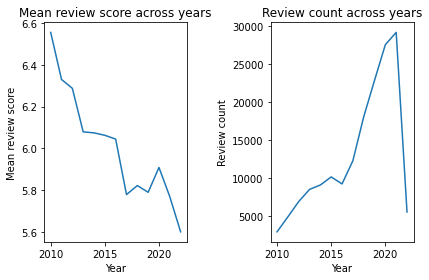

In [ ]:
# First, make a list of the year in which each review was written
year_list=[]
for date in review_data['review_date']:
  year_list.append(date.split(' ')[-1])

# Next, make a list of DataFrames, with each element in the list representing all reviews for a specific year
years=['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
year_dfs=[]
for year in years:
  year_dfs.append(review_data[pd.Series(year_list)==year])

# Get review counts and average reviews for each year
review_count=[]
review_mean=[]
for year in year_dfs:
  review_count.append(year.shape[0])
  review_mean.append(year['review_rating'].to_numpy().mean())

# Plot results
x=[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022]
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, review_mean)
ax1.set_title('Mean review score across years')
ax1.set_xlabel('Year')
ax1.set_ylabel('Mean review score')
ax2.plot(x, review_count)
ax2.set_title('Review count across years')
ax2.set_xlabel('Year')
ax2.set_ylabel('Review count')
f.tight_layout()

This is a very intersting result! Firstly, it is clear that reviews have increasingly become more cynical across the years. This could be a result of a maturing of the online review format: As people become more used to watching, reading, and writing online film reviews, they might also be becoming more critical.

The second figure also reveals something interesting: in 2017, people started writing way more IMDB reviews. If you look at the [top grossing movies of that year](https://www.boxofficemojo.com/year/2017/), it may reveal why. There are five super hero movies in the top ten highest grosing films of that year! These are films with passionate fan bases, who are likely to engage with the critical discourse online. Additionally, two *Star Wars* films came out that year, with one of them being *The Last Jedi*, a highly controvercial film in the *Star Wars* cannon, which produced a tsunami of online discourse. The discussion produced by these films might have introduced new people to IMDB and its review format, creating a boom which is still continuing today.

If you are wondering about the dip at the end, that is for 2022, which at the time of writing is only in the month of May.

# Rating analysis

The first data relavent to training that we will look at are the review ratings. Even although our model is going to be trained for regression, due the contiguous nature of review scores, it is useful to analyze the ratings as if they are discrete classes, as this will reveal potential biases the network might inherit from the data.

Let's look at the distribution and size of our dataset:

Number of reviews: 167634
Mean: 5.9
Median: 7.0


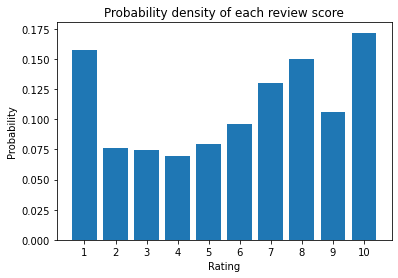

In [ ]:
# Get review ratings
ratings=review_data['review_rating'].to_numpy()

# Print relevant data information
print(f"Number of reviews: {len(ratings)}")
print(f'Mean: {round(ratings.mean(),1)}')
print(f'Median: {round(np.median(ratings),1)}')

# Plod PDF of review scores
x=[1,2,3,4,5,6,7,8,9,10]
plt.title("Probability density of each review score")
plt.xlabel('Rating')
plt.ylabel('Probability')
plt.bar(x, np.histogram(ratings,density=True)[0], align='center')
plt.xticks(x)
plt.show()

As we see here, we scraped a dataset with a whopping **167,634** data points. This is significantly more than the IMDB dataset commonly used for sentiment analysis, which has 50,000 reviews. This size increase is appropriate due to the added complexity of the task. 

If we look at the figure above, we see that this dataset is far from balanced. People seem to either **LOVE** a film, and give it **10/10**, or **HATE** a film, and give it **1/10**, with these two ratings accounting for over 30% of all reviews. This is especially true for negative reviews (reviews bellow 5/10), where we see similarily low probabilities for all ratings besides 1/10. Interestingly, 9/10 goes against the trend of increasing probabilities for positive reviews. I think this might be because if people feel that positively about a movie, they will just give it 10/10. Although these probabilities seem strange, as one would hope to see a normally distributed PDF with a mean around 5/10, this distribution looks like this because people are clearly more likely to leave a review if they feel strongly about a film. People don't bother if they find a film average!

If the model shows an excessive bias to rate films either a 1/10 or a 10/10, or a general bias to rate films highly (due to the rightward shift of this distribution), we might have to come back and artificially balance the dataset, but for now lets leave it as is.

# Text analysis

In this section, we are going to look at the actual review text, and the problems the model might have in predicting the review score given this input data. Before I wrote this section, I took some time to read some reviews in their current format, and identify some issues.

Lets look ar the first issue I identified:

In [ ]:
review_text=review_data['review_body']
print(review_text.iloc[1])

This movie is so true showing the heartbreaking side of family members suffering from Alzheimers. Anybody who has no been in the same situation cannot relate to it how it destroys the family rather than the person suffering Alzheimers. Worthwhile for anybody watching this movie who has a similar situation. You are not alone, as sad as it is.The Alzheimers sufferers are even trickier and sometimes mean to their family, more as shown in this movie. It is a sad path of life. I can relate to this story or subject from own experience and I feel for the producer and his family.
                
                    0 out of 0 found this helpful.
                        
                            Was this review helpful?  Sign in to vote.
                        
                        
                    Permalink


Shorter reviews have this bit about review helpfullness at the end. Let's remove that from our reviews, and save a new clean dataset. This is the only preprocessing we will be doing manually, with the rest handled by *huggingface*.

In [ ]:
# Get rid of helpfullness comment
for i,review_body in enumerate(review_data['review_body']):
  # We search for a common identifier in all reviews with the comment
  if review_body.find('\n                \n                    ')!=-1:
    # And then truncate the review to chop off the comment
    review_data['review_body'].iloc[i]=review_body[:review_body.find('\n                \n                    ')]

# Save the processed dataset
review_data.to_csv('review_data_clean.csv',index=False)

While we are at it, let's make a dataset of just review text (the model input) and ratings (the model target) to use during training:

In [ ]:
training_data=pd.DataFrame(zip(review_data.review_body,review_data.review_rating))
training_data.to_csv('review_data_learning.csv',index=False)

I would now like to dive into the two main problems that I identified in the dataset:

1.   Rating inconsistency
2.   A lack of information content in the input data

Let's explore these issues, by way of an example:

In [ ]:
print("Review 1: "+review_data.review_body.iloc[2702]+'\n')
print("Review 2: "+review_data.review_body.iloc[1782])

Review 1: It works, but really is a little overboard. A touch too moderized.

Review 2: What a ludicrous script! What poor and stupid choices made by virtually every member of the fraternity. Anyone with half a brain would not react to the various situations as the characters did in this movie and therefore, you develop absolutely no feeling for any of the them. So with all the non-suspenseful action and screaming-at-each-other dialogue, the movie becomes a bore.


These reviews are very different in their sentiment and intensity, yet both reviews gave the same rating. A related issue exists for reviews which are very similar, yet assign a different score. This issue of rating inconsistency could produce undesired variance in the predictions of the trained model, as there is a lack of consistency in the review content for each rating. This issue is prevalent across review scores, and acts as noise in our dataset.

To introduce the second problem, I would like you to try and guess what score was left for *Review 1*. Not easy is it? This is because there is a too little information in this review, and many others, to accurately predict a score. This can be thought of as a sparcity issue, as there is a lack of useful features in some input data. This problem will also produce model variance.

For those wondering, these reviews both had a score of 3/10. Was your guess right? How could we expect a model to do better if we can't even guess it!

To close out this analysis, let's generate an ever controvercial **Word Cloud**.

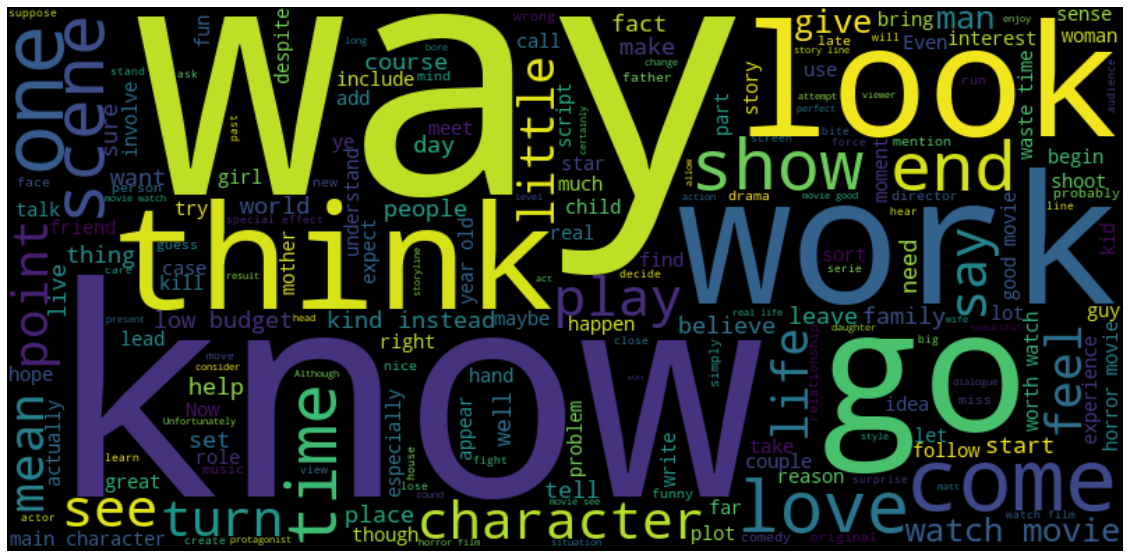

In [ ]:
# Make corpus
body_list= review_data['review_body'].tolist()
corpus=' '.join(body_list)

# Remove stop words
corpus=remove_stopwords(corpus)

# Lemmatize corpus using spacy
nlp = spacy.load('en', disable=['parser', 'ner','tagger','textcat'])
# Increase length of spacy tokenizer
nlp.max_length=169375813+1
doc = nlp(corpus)

# Extract the lemma for each token
word_list=[]
for token in doc:
  # Pronouns are lemmatized to PRON, so we need to change that
  if token.lemma_ == '-PRON-' or token.lemma_ == "PRON":
    token.lemma_ = token.orth_
  word_list.append(token.lemma_)
del doc
corpus=" ".join(word_list)
del word_list

# Generate a word cloud image
wordcloud = WordCloud(collocations=True,width=800,height=400).generate(corpus)

# Display the generated image:
plt.figure(figsize = (20,10))
plt.imshow(wordcloud, interpolation='bilinear',aspect='auto')
plt.axis("off")
plt.show()

Wow. I will leave it up to you to interpret the swath of information one can get from this word cloud. 

Now that we better understand our data, we can move on to training our model and analyzing the results. You can find this next step on the [repo](https://github.com/shaikadish/imdbProject)!